In [10]:
from tqdm import tqdm
import numpy as np
from itertools import product

from perlin_numpy import generate_perlin_noise_3d

In [2]:
def calculate_distance(center_coords, grid_size=128):
    distances = np.zeros((grid_size**3, len(center_coords)))

    vox_coord = list(
        product(range(grid_size), range(grid_size), range(grid_size)),
    )

    for i in tqdm(range(distances.shape[0]), desc="computing distances"):
        distances[i] = np.sqrt(
            np.sum((np.array(vox_coord[i]) - center_coords) ** 2, axis=1)
        )

    return distances

In [14]:
def initial_label_generator(grid_size=128, r_mean=12):

    Nz, Ny, Nx = (grid_size,) * 3

    x = np.arange(0, grid_size, 2 * r_mean)[1:-1]
    Z, Y, X = np.meshgrid(x, x, x, indexing="ij")  

    points = np.stack(
        [Z.flatten(), Y.flatten(), X.flatten()]
    ).T  # center coordinates flattened
    points = (points).astype(np.float32)
    points_perturbed = points + 0.5 * r_mean * np.random.uniform(-1, 1, points.shape)

    ind = np.arange(len(points_perturbed))  
    np.random.shuffle(ind) 

    ind_keep = ind[: np.random.randint(2 * len(ind) // 3, len(ind))]  
    points_perturbed_kept = points_perturbed[ind_keep]  

    rads = r_mean * np.random.uniform(0.6, 1.2, len(points))  
    rads_kept = rads[ind_keep]  

    dist_mtx = calculate_distance(points_perturbed_kept)

    # Sample perlin noise:
    noise_sample = generate_perlin_noise_3d((Nz, Ny, Nx), res=(8, 8, 8))

    # Corrupt distance matrix:
    corr_dist_mtx = dist_mtx + 0.9 * r_mean * noise_sample.flatten()[:, np.newaxis]

    labelmap = np.zeros(grid_size**3, dtype=np.uint16)  
    orig_labelmap = np.zeros(grid_size**3, dtype=np.uint16)
    for j in tqdm(range(dist_mtx.shape[0])):
        finder = np.where(corr_dist_mtx[j, :] < rads_kept)[0]
        finder_orig = np.where(dist_mtx[j, :] < rads_kept)[0]
        if len(finder) > 0:
            # in case of match with more than label, assign to closest:
            value = finder[np.argmin(corr_dist_mtx[j, finder])]
            labelmap[j] = value + 1
        if len(finder_orig) > 0:
            val = finder_orig[np.argmin(dist_mtx[j, finder_orig])]
            orig_labelmap[j] = val + 1

    labelmap = np.reshape(labelmap, (grid_size, grid_size, grid_size))
    orig_labelmap = np.reshape(orig_labelmap, (grid_size, grid_size, grid_size))
    return labelmap, noise_sample, orig_labelmap


In [15]:
label = initial_label_generator(grid_size=128, r_mean=12)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2097152/2097152 [00:10<00:00, 198642.34it/s]


In [16]:
import matplotlib.pyplot as plt

In [17]:
corr_label, perlin, orig_label = label

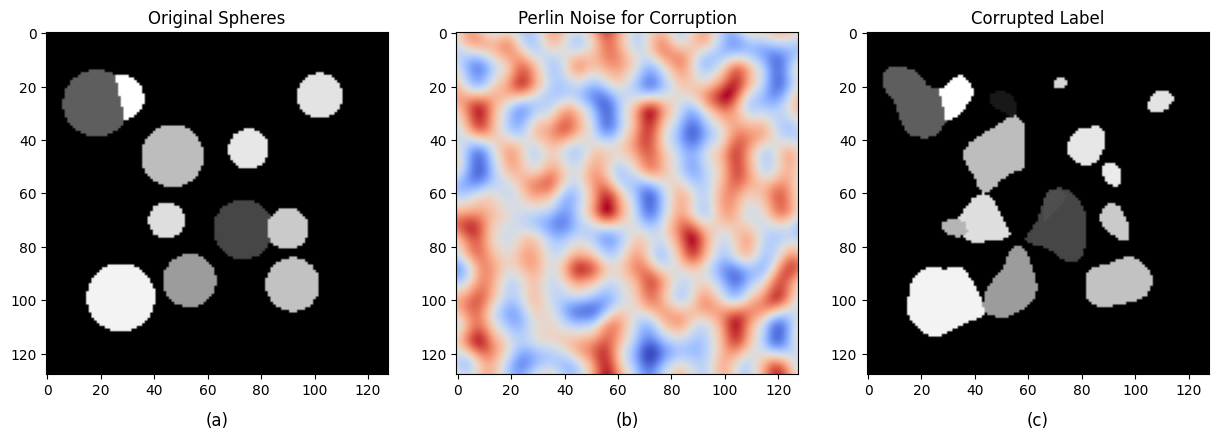

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5.))

ax[0].imshow(orig_label[64,...], cmap='gray')
ax[0].set_title("Original Spheres")
#fig.colorbar(im0, ax=ax[0], orientation='vertical')
ax[0].text(0.5, -0.15, "(a)", size=12, ha="center", transform=ax[0].transAxes)

ax[1].imshow(perlin[64, ...], cmap='coolwarm')
ax[1].set_title("Perlin Noise for Corruption")
ax[1].text(0.5, -0.15, "(b)", size=12, ha="center", transform=ax[1].transAxes)

ax[2].imshow(corr_label[64, ...], cmap='gray')
ax[2].set_title("Corrupted Label")
ax[2].text(0.5, -0.15, "(c)", size=12, ha="center", transform=ax[2].transAxes)

plt.savefig('perlin-corruption.png', dpi=300)
plt.show()

In [26]:
pwd

'/net/vast-storage/scratch/vast/gablab/ckapoor/lsm-segmentation/lsm/synthetic'

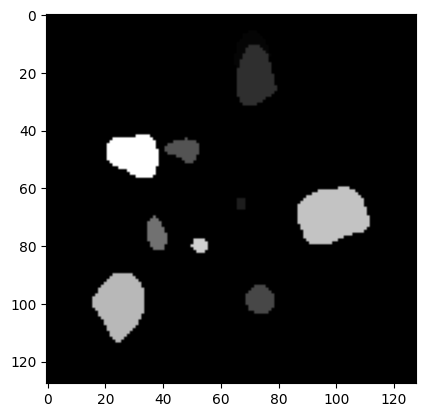

In [13]:
plt.imshow(label[64,...], cmap='gray')

# synth dataset

In [34]:
import nibabel as nib

In [45]:
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

url = "https://dandiarchive.s3.amazonaws.com/zarr/0bda7c93-58b3-4b94-9a83-453e1c370c24/"
reader = Reader(parse_url(url))
dask_data = list(reader())[0].data
scale = 0
vol_scale = dask_data[scale][0]
vol_scale = np.transpose(vol_scale, (1, 2, 3, 0))

In [46]:
chunk_size = 128
voxel = vol_scale[
        1000 : 1000 + chunk_size, 650 : 650 + chunk_size, 3500 : 3500 + chunk_size]

In [81]:
# load synth images
anystar = nib.load('/om2/user/ckapoor/AnyStar/generative_model/outputs/training_images/stack_0000/stack_0000_0000_v10.nii.gz').get_fdata()
anystar_gauss = nib.load('/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/training_images/stack_0007/stack_0007_0000_v14.nii.gz').get_fdata()
anystar_sph = nib.load('/om2/user/ckapoor/generative_model_steerable_harmonics/outputs/training_images/stack_0009/stack_0009_0000_v1.nii.gz').get_fdata()

# alpha blending

In [95]:
orig_labels = nib.load(f'/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/initial_labels/stack_0000.nii.gz').get_fdata()
randmode = np.random.choice(['constant', 'reflect'])
randpad_x = np.random.choice([0, 32, 64, 96])
randpad_y = np.random.choice([0, 32, 64, 96])
randpad_z = np.random.choice([0, 32, 64, 96])

In [96]:
# pad label image
padded_labels = np.pad(
                orig_labels,
                [
                    [randpad_x, randpad_x],
                    [randpad_y, randpad_y],
                    [randpad_z, randpad_z],
                ],
                mode=randmode,
)

# resize labels
from skimage.transform import resize
current_labels = resize(
                padded_labels,
                (128, 128, 128),
                preserve_range=True,
                anti_aliasing=False,
                order=0,)

from skimage.measure import label as unique_label

current_labels = unique_label(current_labels).astype(np.uint16)

# begin GMM procedure
means = draw_value_from_distribution(
                None,
                len(np.unique(current_labels)),
                "uniform",
                125,
                100,
                positive_only=True,
            )
stds = draw_value_from_distribution(
                None,
                len(np.unique(current_labels)),
                "uniform",
                15,
                10,
                positive_only=True,
            )

In [97]:
backgnd_mode = np.random.choice(["plain", "rand", "perlin"])
print(f'bg mode: {backgnd_mode}')

bg mode: rand


In [98]:
if backgnd_mode == "plain":                                 
    min_mean = means.min() * np.random.rand(1)              
    means[0] = 1.0 * min_mean                               
    stds[0] = np.random.uniform(0.0, 5.0, 1)                
elif backgnd_mode == "perlin":                              
    # Inspired by the sm-shapes generative model from       
    # https://martinos.org/malte/synthmorph/                
    n_texture_labels = np.random.randint(1, 21)             
    idx_texture_labels = np.arange(0, n_texture_labels, 1)  
    im = ne.utils.augment.draw_perlin(                      
        out_shape=(128, 128, 128, n_texture_labels),        
        scales=(32, 64),                                    
        max_std=1,                                          
    )                                                       
    try:                                                    
        warp = ne.utils.augment.draw_perlin(                
            out_shape=(128, 128, 128, n_texture_labels, 3), 
            scales=(16, 32, 64),                            
            max_std=16,                                     
        )                                                   
    except:                                                 
        pass
                                                            
    # Transform and create background label map.            
    im = vxm.utils.transform(im, warp)                      
    background_struct = np.uint8(tf.argmax(im, axis=-1))    
                                                            
    # Background moments for GMM:                           
    background_means = draw_value_from_distribution(        
        None,                                               
        len(np.unique(idx_texture_labels)),                 
        "uniform",                                          
        125,                                                
        100,                                                
        positive_only=True,                                 
    )                                                       
    background_stds = draw_value_from_distribution(         
        None,                                               
        len(np.unique(idx_texture_labels)),                 
        "uniform",                                          
        15,                                                 
        10,                                                 
        positive_only=True,                                 
    )                                                       

In [99]:
# Sample perlin noise for cell texture here                               
randperl = ne.utils.augment.draw_perlin(                                  
    out_shape=(128, 128, 128, 1),                                         
    scales=(2, 4, 8, 16, 32),                                             
    max_std=5.0,                                                          
)[..., 0].numpy()                                                         
randperl = (randperl - randperl.min()) / (randperl.max() - randperl.min())

In [100]:
# Create foreground:                                        
synthlayer = SampleConditionalGMM(np.unique(current_labels))
synthimage = synthlayer(                                    
    [                                                       
        tf.convert_to_tensor(                               
            current_labels[np.newaxis, ..., np.newaxis],    
            dtype=tf.float32,                               
        ),                                                  
        tf.convert_to_tensor(                               
            means[tf.newaxis, ..., tf.newaxis],             
            dtype=tf.float32,                               
        ),                                                  
        tf.convert_to_tensor(                               
            stds[tf.newaxis, ..., tf.newaxis],              
            dtype=tf.float32,                               
        ),                                                  
    ]                                                       
)[0, ..., 0].numpy()             

In [101]:
# Use multiplicative Perlin noise on foreground:                 
synthimage[current_labels > 0] = (                               
    synthimage[current_labels > 0] * randperl[current_labels > 0]
)                                                                
del synthlayer                                                   

In [102]:
if backgnd_mode == "plain" or backgnd_mode == "rand":          
    synthimage[current_labels == 0] = synthimage[              
        current_labels == 0                                    
    ] * np.mean(randperl[current_labels == 0])                 
elif backgnd_mode == "perlin":                                 
    synthlayer = SampleConditionalGMM(idx_texture_labels)      
    synthbackground = synthlayer(                              
        [                                                      
            tf.convert_to_tensor(                              
                background_struct[np.newaxis, ..., np.newaxis],
                dtype=tf.float32,                              
            ),                                                 
            tf.convert_to_tensor(                              
                background_means[tf.newaxis, ..., tf.newaxis], 
                dtype=tf.float32,                              
            ),                                                 
            tf.convert_to_tensor(                              
                background_stds[tf.newaxis, ..., tf.newaxis],  
                dtype=tf.float32,                              
            ),                                                 
        ]                                                      
    )[0, ..., 0].numpy() 
    # corrupt background with perlin noise
    synthimage[current_labels == 0] = synthbackground[         
        current_labels == 0                                    
    ] * np.mean(randperl[current_labels == 0])                 
    del synthlayer               

In [104]:
from scipy.ndimage import gaussian_filter

def gaussian_3d_kernel(size, sigma):
    x, y, z = np.meshgrid(np.linspace(-1, 1, size[0]), 
                          np.linspace(-1, 1, size[1]), 
                          np.linspace(-1, 1, size[2]), indexing='ij')
    distance = np.sqrt(x**2 + y**2 + z**2)
    kernel = np.exp(-(distance**2 / (2.0 * sigma**2)))
    kernel = kernel / np.sum(kernel)
    return kernel

def gaussian_derivative_3d(image, sigma):
    # take 1st derivative along x, y, z
    gx = gaussian_filter(image, sigma=sigma, order=[1, 0, 0])
    gy = gaussian_filter(image, sigma=sigma, order=[0, 1, 0])
    gz = gaussian_filter(image, sigma=sigma, order=[0, 0, 1])
    return gx, gy, gz

def steerable_filter_3d(image, sigma, theta, phi):
    gx, gy, gz = gaussian_derivative_3d(image, sigma)
    
    # steerable filter response
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    # linear combination of basis vectors 
    filtered_image = (cos_theta * cos_phi * gx +
                      sin_theta * cos_phi * gy +
                      sin_phi * gz)
    
    return filtered_image

In [105]:
from scipy.ndimage import rotate

def gaussian_3d_kernel(size, sigma):
    #x, y, z = np.meshgrid(np.random.randn(0, 1, size[0]), 
    #                      np.random.randn(0, 1, size[1]), 
    #                      np.random.randn(0, 1, size[2]), indexing='ij')
    x = np.random.normal(0, 1, size[0])
    y = np.random.normal(0, 1, size[1])
    z = np.random.normal(0, 1, size[2])
    
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    
    distance = np.sqrt(x**2 + y**2 + z**2)
    kernel = np.exp(-(distance**2 / (2.0 * sigma**2)))
    kernel = kernel / np.sum(kernel)
    return kernel

def rotate_3d_kernel(kernel, angles):
    rotated_kernel = rotate(kernel, angle=angles[0], axes=(1, 2), reshape=False)
    rotated_kernel = rotate(rotated_kernel, angle=angles[1], axes=(0, 2), reshape=False)
    rotated_kernel = rotate(rotated_kernel, angle=angles[2], axes=(0, 1), reshape=False)
    return rotated_kernel

In [108]:
from scipy.ndimage import convolve
x = np.random.randn(128, 128, 128) # image slice

test_kernel = gaussian_3d_kernel(size=(7, 7, 7), sigma=1.)
theta = np.random.uniform(0, 360)
psi = np.random.uniform(0, 360)
phi = np.random.uniform(-90, 90)
rotate_kernel = rotate_3d_kernel(kernel=test_kernel, angles=(theta, phi, psi))
steerable_random_conv = convolve(x, rotate_kernel)

In [111]:
orig_img = synthimage

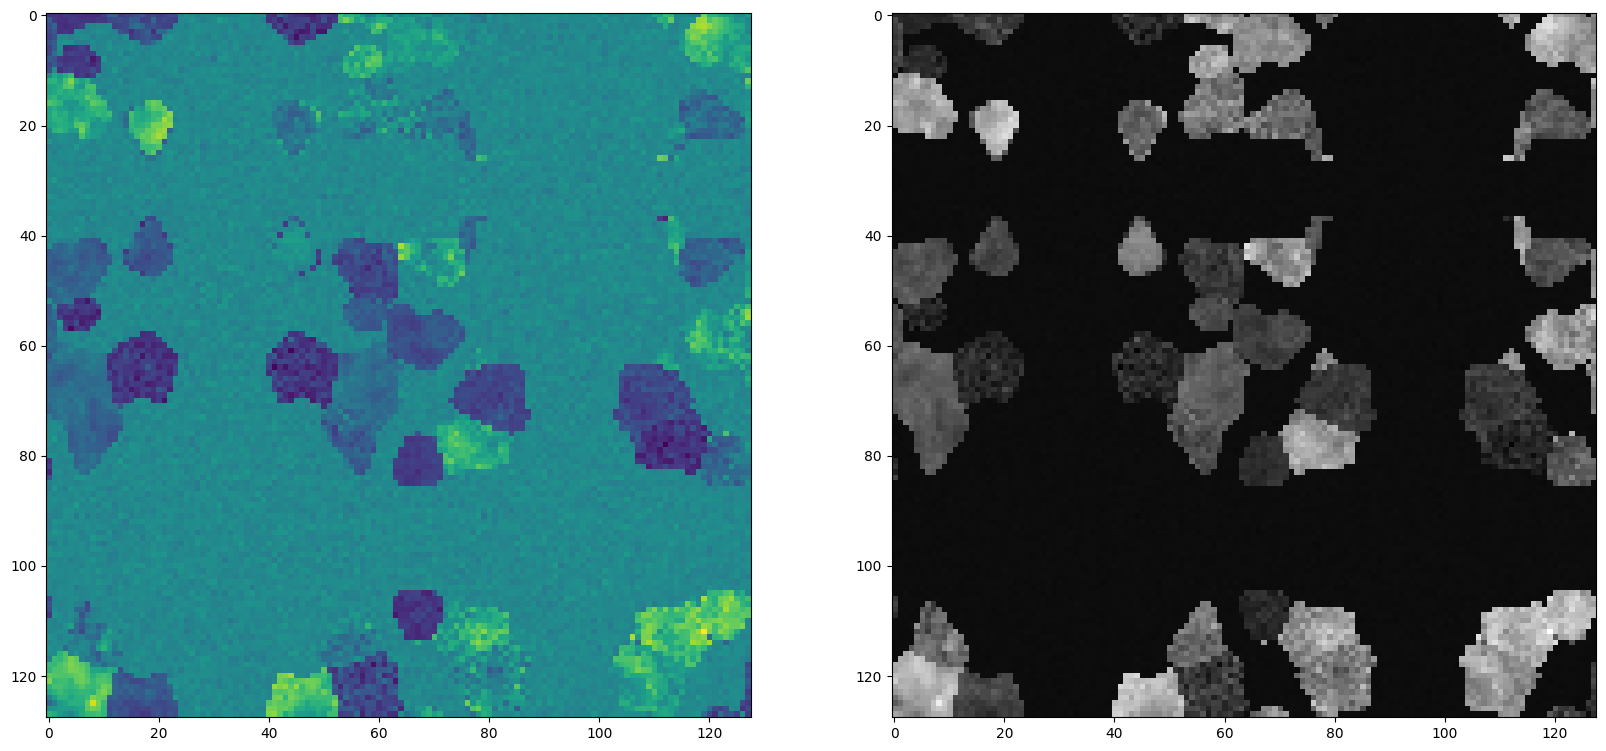

In [113]:
alpha = 0.5
#blended = cv.addWeighted(orig_img, alpha, conv_pattern.astype('float32'), 1-alpha, 0)
blended = orig_img.copy()
blended[current_labels == 0] = conv_pattern[current_labels == 0] * alpha # only corrupt background

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(orig_img[64,...])
plt.subplot(1, 2, 2)
plt.imshow(blended[64,...], cmap='gray')